# ***Advanced Lane Line Finding***


# Camera Calibration and Distortion Correction

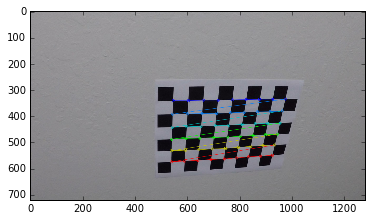

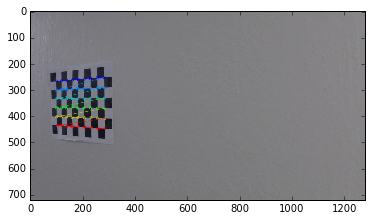

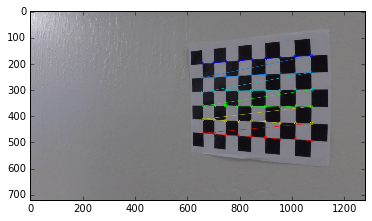

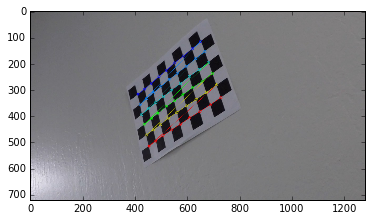

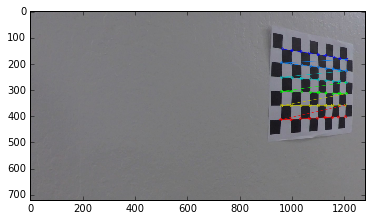

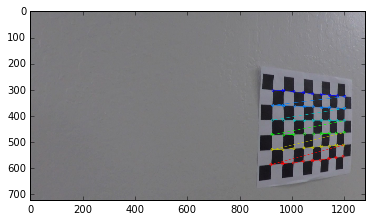

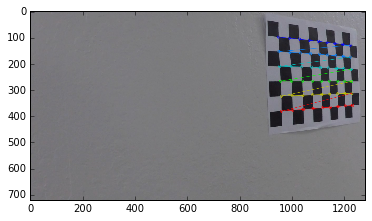

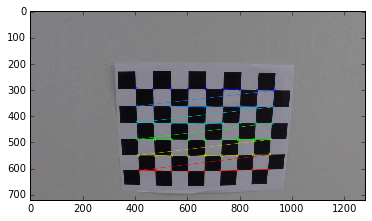

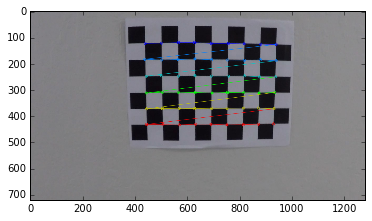

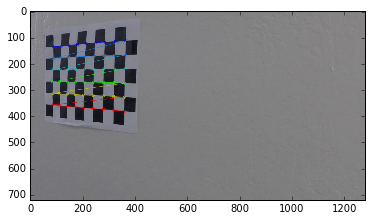

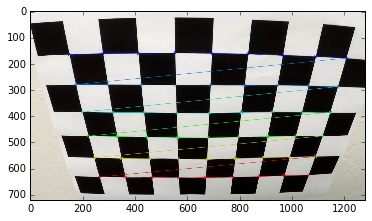

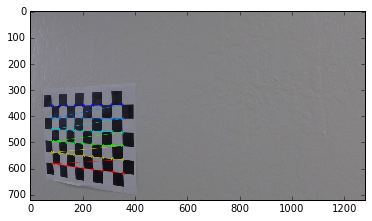

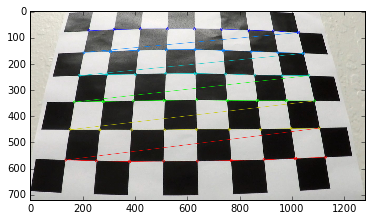

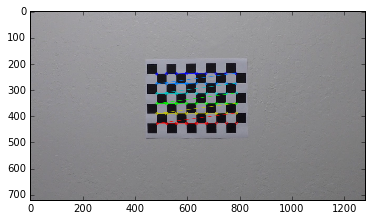

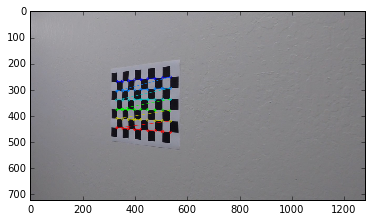

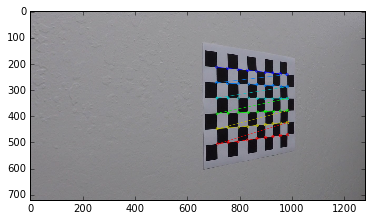

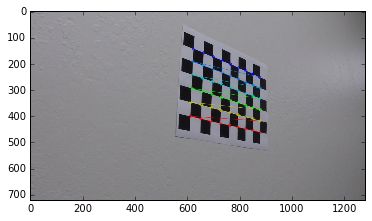

In [1]:
#importing required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

#set the corners
nx = 9
ny = 6

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny * nx, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


# Read all images and find corners
for fname in images:
    #Read an image
    img = mpimg.imread(fname)
    
    #Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        plt.figure()
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)


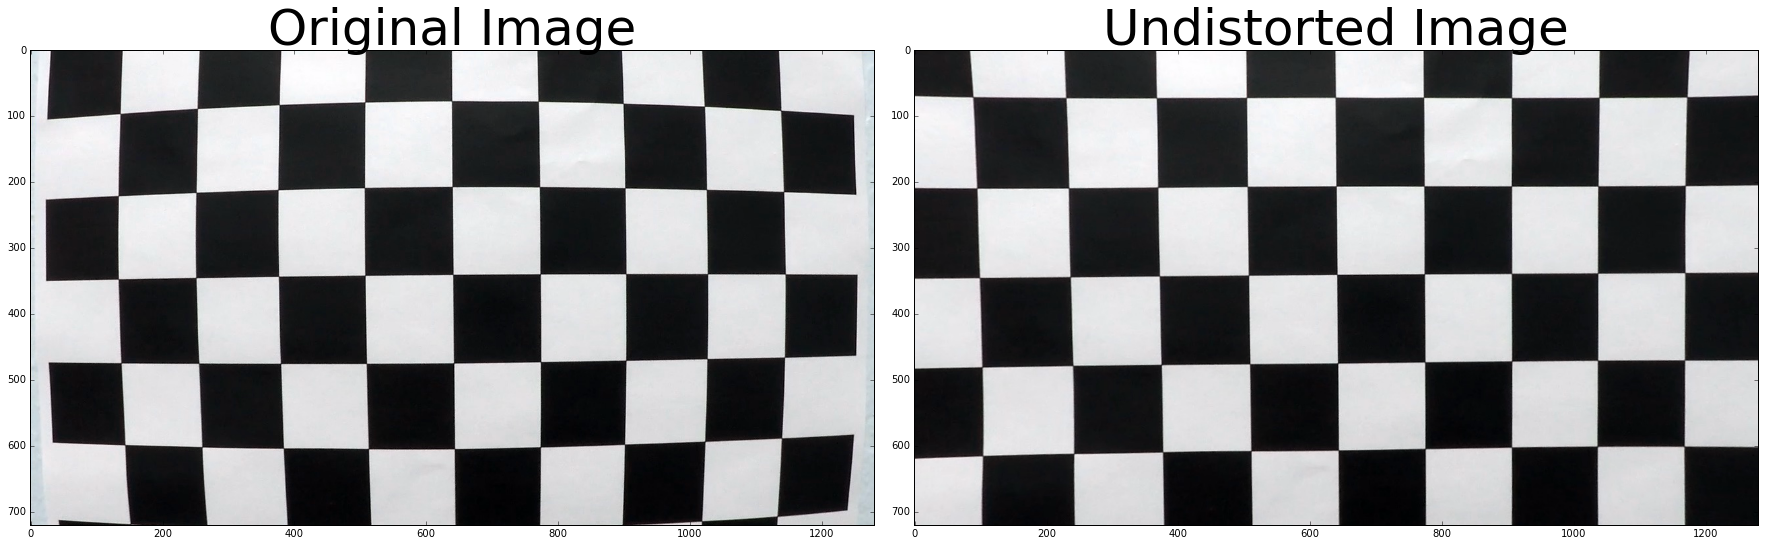

In [2]:
#function to perform undistortion given an image, object points and image points
def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Use cv2.calibrateCamera() to calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    #use cv2.undistort() to undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #return the distortion corrected image
    return undist, mtx, dist

#read an image to perform distortion correction
img = cv2.imread('camera_cal/calibration1.jpg')

#Use the read image to test the distiortion correction 
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

#plot both the original and distortion corrected images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Color/gradient threshold

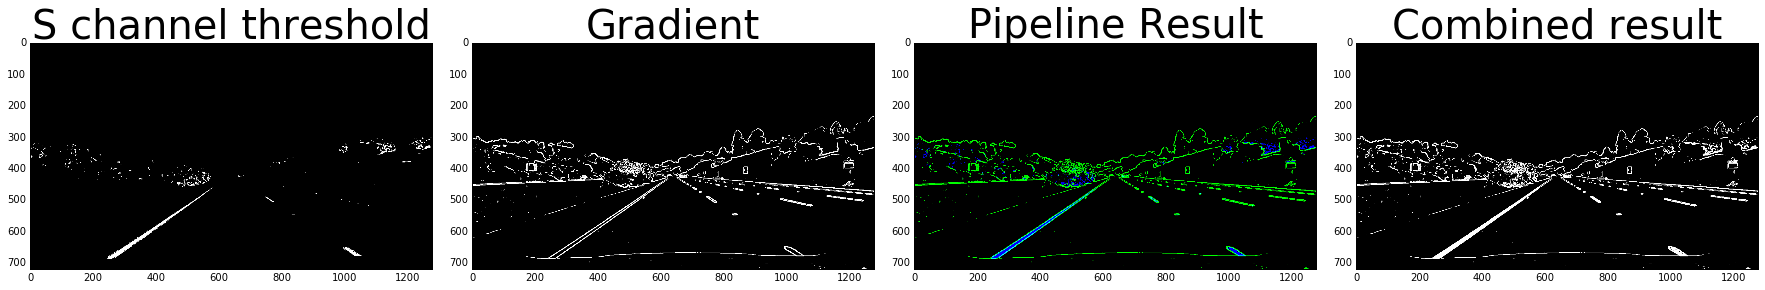

In [3]:
#Function to take gradient in x or y direction and return a binary output after thresholding
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    #convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #based on the orient, take gradient in x or y direction
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #Compute the absolute of the gradient and normalize to 255
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #initialize the output image
    binary_output = np.zeros_like(scaled_sobel)
    #apply the threshholds
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    #return the thresholded binary image    
    return binary_output

#function to apply thresholding on a specific channel
# Function that applies Sobel x and y, then computes the magnitude of the gradient and return a binary output after thresholding
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    #convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Compute the magnitude of gradients in x and y directions
    sobel = np.sqrt(np.square(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)) + np.square(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)))
        
    #Compute the absolute of the gradient and normalize to 255
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
    #initialize the output image
    binary_output = np.zeros_like(scaled_sobel)
    #apply the threshholds
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    #return the thresholded binary image    
    return binary_output


# Function that applies Sobel x and y, then computes the direction of the gradient and return a binary output after thresholding
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #convert the image to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Compute the gradient in x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #Calculate the direction of the gradient
    arctanabs = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    #initialize the output image
    binary_output = np.zeros_like(arctanabs)
    #apply the threshholds
    binary_output[(arctanabs >= thresh[0]) & (arctanabs <= thresh[1])] = 1
    #return the thresholded binary image    
    return binary_output


# Function that thresholds the S-channel of HLS space
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    #Convert the image to HLS space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    #initialize the output image
    binary_output = np.zeros_like(S)
    #apply the threshholds
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    #return the thresholded binary image    
    return binary_output

#read an image to perform thresholding operation
lane_image = mpimg.imread('test_images/straight_lines1.jpg')

#perform gradient thresholding
grad_result = mag_thresh(lane_image,sobel_kernel=5,mag_thresh=(50,240))

#perform color thresholding
col_result = hls_select(lane_image,thresh=(150,255))

color_binary = np.dstack(( np.zeros_like(grad_result), grad_result, col_result))

#Combine the two binary thresholds
combined_binary = np.zeros_like(col_result)
combined_binary[(grad_result == 1) | (col_result == 1)] = 1

# Plot the result
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(col_result, cmap='gray')
ax1.set_title('S channel threshold', fontsize=40)

ax2.imshow(grad_result, cmap='gray')
ax2.set_title('Gradient', fontsize=40)

ax3.imshow(color_binary*255)
ax3.set_title('Pipeline Result', fontsize=40)

ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#  Perspective transform

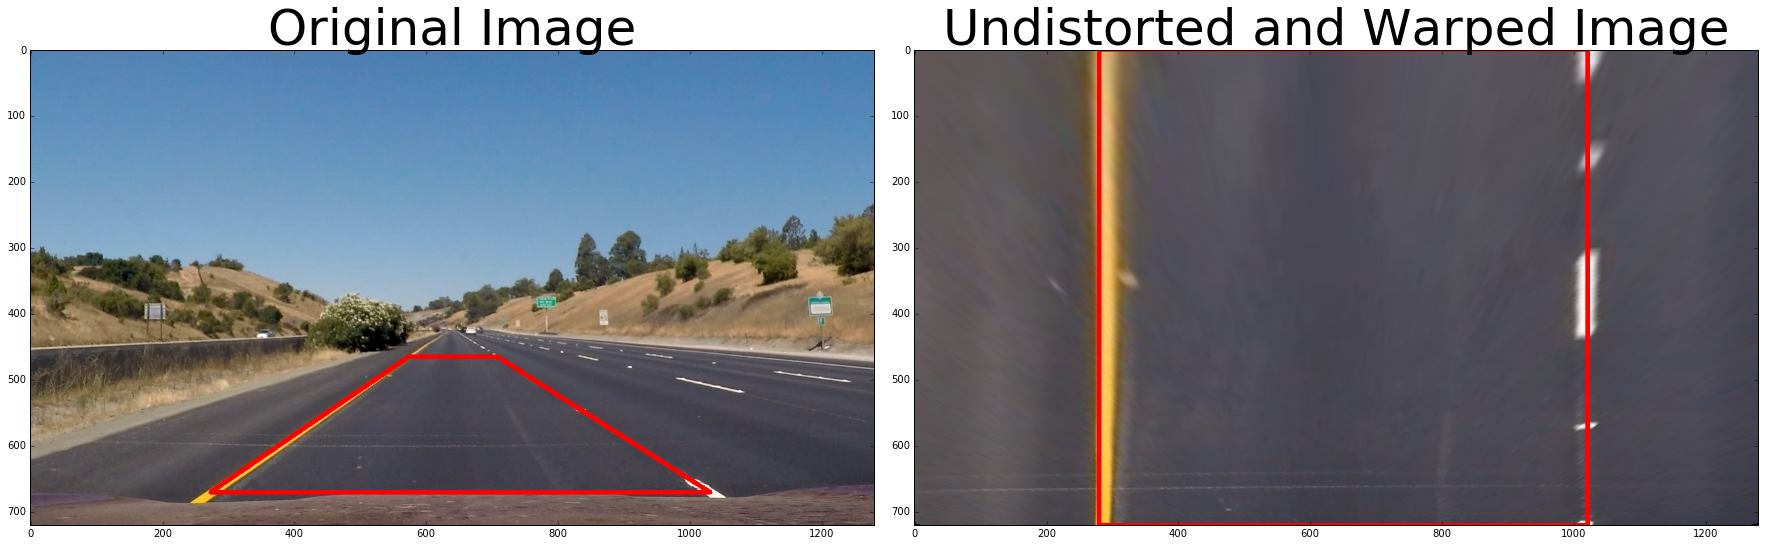

In [4]:
#function to perform perspective transform
def pers_transform(img, mtx, dist,src,dst):
    img_size = (img.shape[1], img.shape[0])
    #undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #calculate the perspective matrix
    M = cv2.getPerspectiveTransform(src, dst)
    #unwarp the image
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M

#draw the src/dst lines on the image
def draw_lines(img,points,color=[255,0,0]):
    cv2.line(img,tuple(points[0]),tuple(points[1]),color,5)
    cv2.line(img,tuple(points[1]),tuple(points[2]),color,5)
    cv2.line(img,tuple(points[2]),tuple(points[3]),color,5)
    cv2.line(img,tuple(points[3]),tuple(points[0]),color,5)
    return img
    
#read an image to calculate the perspective matrix and perform unwarping
img = mpimg.imread('test_images/straight_lines1.jpg')

#set the src and dst points, currently this is hard coded by looking at the points.
src = np.float32([[1030,670],[708,465],[573,465],[273,670]])
dst = np.float32([[1020,720],[1020,0],[280,0],[280,720]])
top_down, perspective_M =  pers_transform(img, mtx, dist,src,dst)

#draw src and dst lines on respective images
draw_lines(img,src)
draw_lines(top_down,dst)

#plot the resultd
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Lane line finding and fitting a polynomial

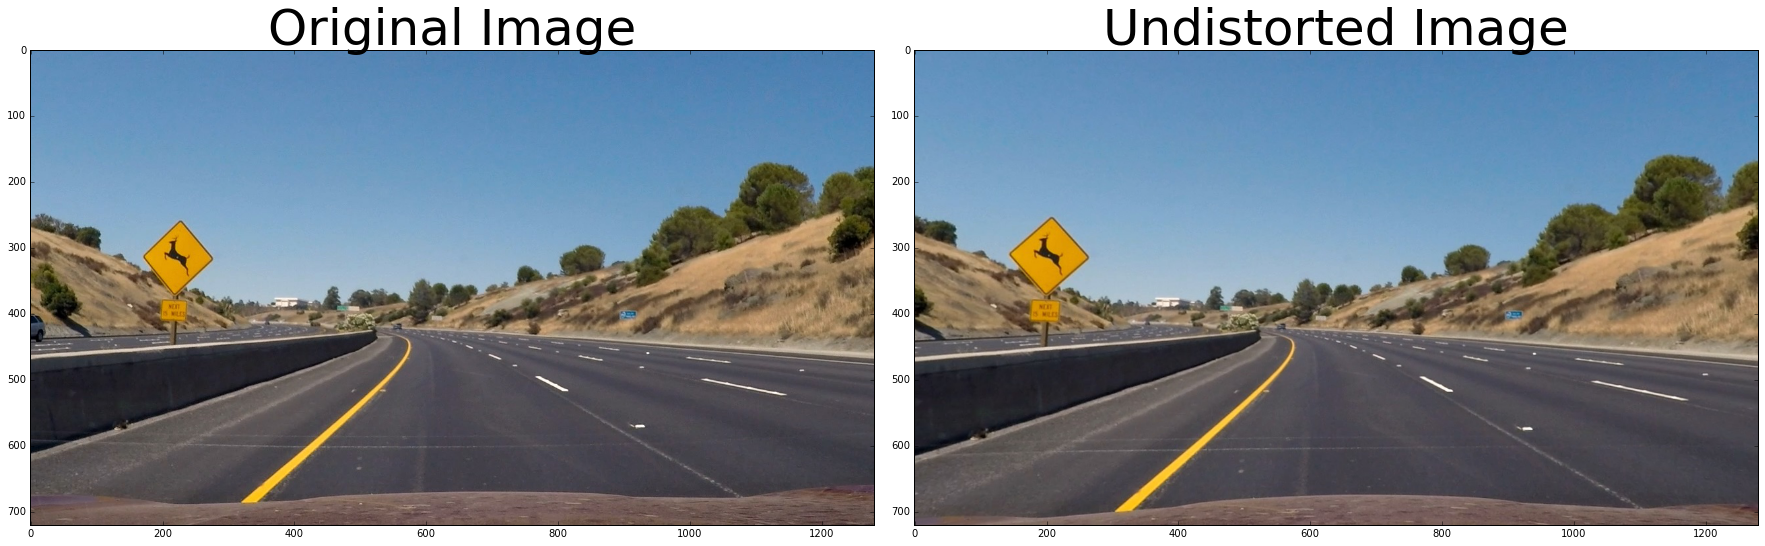

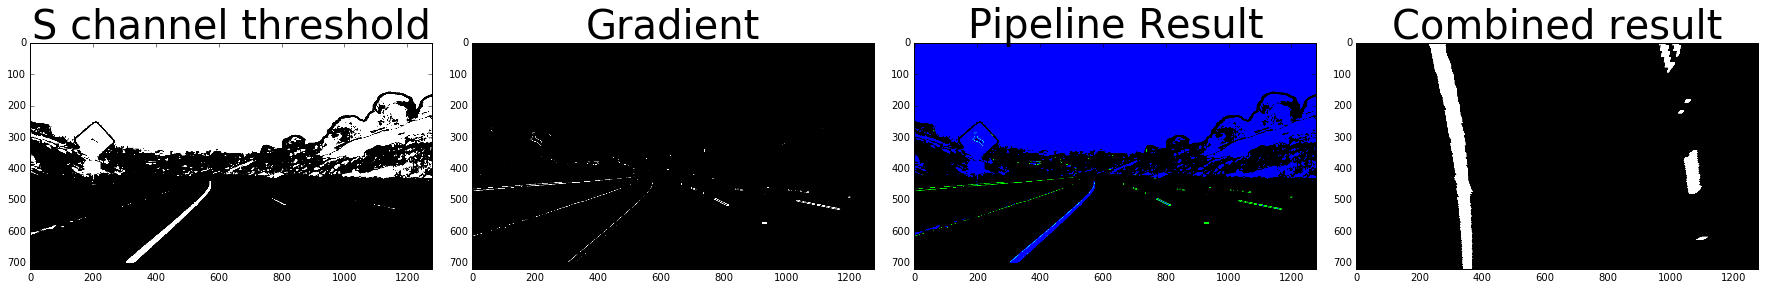

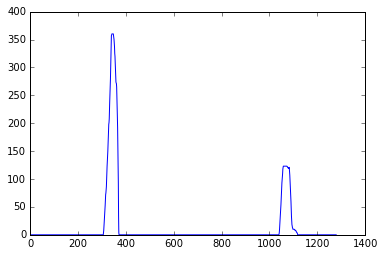

In [16]:
#read a test image 
img = mpimg.imread('test_images/test2.jpg')

#get the undistorted and unwraped image
img_size = (img.shape[1], img.shape[0])
undist = cv2.undistort(img, mtx, dist, None, mtx)

#plot the undistorted test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#perform thresholding
grad_result = mag_thresh(undist,sobel_kernel=5,mag_thresh=(130,255))
col_result = hls_select(undist,thresh=(75,255))
color_binary = np.dstack(( np.zeros_like(grad_result), grad_result, col_result))

#Combine the two binary thresholds
combined_binary = np.zeros_like(col_result)
combined_binary[(grad_result == 1) | (col_result == 1)] = 1

#perform perspective transform on the binary image
combined_binary = cv2.warpPerspective(combined_binary, perspective_M, img_size, flags=cv2.INTER_LINEAR)

# Plot the result
f, (ax1, ax2,ax3,ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(col_result, cmap='gray')
ax1.set_title('S channel threshold', fontsize=40)

ax2.imshow(grad_result, cmap='gray')
ax2.set_title('Gradient', fontsize=40)

ax3.imshow(color_binary*255)
ax3.set_title('Pipeline Result', fontsize=40)

ax4.imshow(combined_binary, cmap='gray')
ax4.set_title('Combined result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#calculate histogram of the binary image
histogram = np.sum(combined_binary[int(combined_binary.shape[0]/2):,:], axis=0)
plt.figure()
plt.plot(histogram)

In [17]:
#function to perform sliding window search
def sliding_window(binary_warped, plot_polynomial=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if (plot_polynomial):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return right_fitx, left_fitx,ploty, right_fit, left_fit

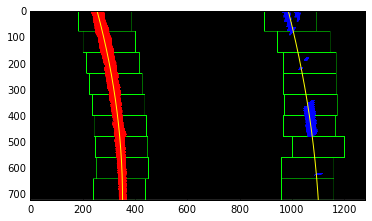

In [18]:
#perform sliding window search
right_fitx, left_fitx,ploty, right_fit, left_fit = sliding_window(combined_binary, True )

#function to get the fit without window search
def skip_sliding_window(binary_warped,left_fit,right_fit):
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return right_fitx, left_fitx,ploty, right_fit, left_fit

In [19]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#function to radius of curvature and offset
def get_curvature_centeroffset(ploty,leftx,rightx):
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    #calculate the offset
    left_lane = leftx[len(leftx)-1]
    right_lane = rightx[len(rightx)-1]
    center = (((left_lane + right_lane) / 2) - 640) * xm_per_pix

    return (left_curverad+right_curverad)/2, center

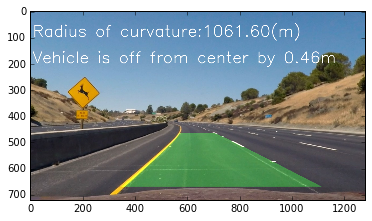

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#function to draw the lane and to add radius of curvature and offset
def add_requiredinfo(binary_warped,undist,radius,center,ploty,left_fitx,right_fitx ):

    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,"Radius of curvature:"+str(radius)+"(m)",(10,100), font, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,"Vehicle is off from center by "+str(center)+"m ",(10,200), font, 2,(255,255,255),2,cv2.LINE_AA)
    return result

#calculate the radius of curvature and offset
radius,center = get_curvature_centeroffset(ploty,left_fitx,right_fitx)
#draw the lane
result = add_requiredinfo(combined_binary,undist,"{0:.2f}".format(radius),"{0:.2f}".format(center),ploty,left_fitx,right_fitx)
plt.imshow(result)

In [21]:
#function to combine all actions
def combined_processing(image):

    #step-1 get the undistorted image
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    #step-2 perform thresholding and get the binary image
    grad_result = mag_thresh(undist,sobel_kernel=5,mag_thresh=(130,255))
    col_result = hls_select(undist,thresh=(75,255))
    color_binary = np.dstack(( np.zeros_like(grad_result), grad_result, col_result))
    combined_binary = np.zeros_like(col_result)
    combined_binary[(grad_result == 1) | (col_result == 1)] = 1
    #step-3 perform perspective transform
    combined_binary = cv2.warpPerspective(combined_binary, perspective_M, img_size, flags=cv2.INTER_LINEAR)
    #step-4 perform sliding window search
    right_fitx, left_fitx,ploty, right_fit, left_fit = sliding_window(combined_binary)
    
    #step-5 Calculate the radius and center
    radius,center = get_curvature_centeroffset(ploty,left_fitx,right_fitx)
    #step-6 add the required info
    return add_requiredinfo(combined_binary,undist,"{0:.2f}".format(radius),"{0:.2f}".format(center),ploty,left_fitx,right_fitx)

In [22]:
project_output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(combined_processing) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4



100%|█████████████████████████████████████▉| 1260/1261 [09:37<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 10min 11s
